In [ ]:

import pandas as pd
df = pd.read_csv('transformed_dataset.csv')

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression

class MultiModelClassifier:
    def __init__(self):
        self.models = {
            'linear_svc': LinearSVC(
            multi_class='ovr',
            max_iter=1000,
            class_weight='balanced'
        )
        }
        self.results = {}

    def evaluate_models(self, X_train, X_test, y_train, y_test, category_level):
        """Evaluate all models for a specific category level"""
        print(f"\nEvaluating models for {category_level}")
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            try:
                # Train the model
                model.fit(X_train, y_train)
                
                # Make predictions
                y_pred = model.predict(X_test)
                
                # Calculate metrics
                report = classification_report(y_test, y_pred)
                
                self.results[f"{category_level}_{name}"] = {
                    'model': model,
                    'report': report,
                    'predictions': y_pred
                }
                
                print(f"\n{name} Results:")
                print(report)
                
            except Exception as e:
                print(f"Error with {name}: {str(e)}")

def compare_models(X, y1, y2, y3):
    """Compare different models for each category level"""
    # Split data
    X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
        X, y1, y2, y3, test_size=0.2, random_state=42
    )
    
    # Initialize classifier
    classifier = MultiModelClassifier()
    
    # Evaluate for each level
    classifier.evaluate_models(X_train, X_test, y1_train, y1_test, "Level1")
    classifier.evaluate_models(X_train, X_test, y2_train, y2_test, "Level2")
    classifier.evaluate_models(X_train, X_test, y3_train, y3_test, "Level3")
    
    return classifier.results

# Enhanced version with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

class TunedMultiModelClassifier:
    def __init__(self):
        self.model_params = {
            'random_forest': {
                'model': RandomForestClassifier(class_weight='balanced'),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [None, 10, 20],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'xgboost': {
                'model': XGBClassifier(),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [5, 7, 9],
                    'learning_rate': [0.01, 0.1],
                    'min_child_weight': [1, 3, 5]
                }
            },
            'lightgbm': {
                'model': LGBMClassifier(verbose =  -1),
                'params': {
                    'n_estimators': [100, 200],
                    'max_depth': [5, 7, 9],
                    'learning_rate': [0.01, 0.1],
                    'num_leaves': [31, 63, 127]
                }
            }
        }
        self.results = {}

    def tune_and_evaluate(self, X_train, X_test, y_train, y_test, category_level):
        """Tune hyperparameters and evaluate models"""
        print(f"\nTuning and evaluating models for {category_level}")
        
        for name, config in self.model_params.items():
            print(f"\nTuning {name}...")
            try:
                # Create GridSearchCV object
                grid_search = GridSearchCV(
                    config['model'],
                    config['params'],
                    cv=5,
                    n_jobs=-1,
                    verbose=1
                )
                
                # Fit grid search
                grid_search.fit(X_train, y_train)
                
                # Get best model
                best_model = grid_search.best_estimator_
                
                # Make predictions
                y_pred = best_model.predict(X_test)
                
                # Calculate metrics
                report = classification_report(y_test, y_pred)
                
                self.results[f"{category_level}_{name}"] = {
                    'model': best_model,
                    'best_params': grid_search.best_params_,
                    'report': report,
                    'predictions': y_pred
                }
                
                print(f"\n{name} Results:")
                print(f"Best parameters: {grid_search.best_params_}")
                print(report)
                
            except Exception as e:
                print(f"Error with {name}: {str(e)}")

# Usage example
def main():
    # Load and preprocess your data
    # X = ... # Your feature matrix
    # y1, y2, y3 = ... # Your target variables
    
    # Basic model comparison
    print("Running basic model comparison...")
    results = compare_models(X, y1, y2, y3)
    
    # Tuned model comparison
    print("\nRunning tuned model comparison...")
    tuned_classifier = TunedMultiModelClassifier()
    
    # Split data
    X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
        X, y1, y2, y3, test_size=0.2, random_state=42
    )
    
    # Tune and evaluate for each level
    tuned_classifier.tune_and_evaluate(X_train, X_test, y1_train, y1_test, "Level1")
    tuned_classifier.tune_and_evaluate(X_train, X_test, y2_train, y2_test, "Level2")
    tuned_classifier.tune_and_evaluate(X_train, X_test, y3_train, y3_test, "Level3")
    
    return results, tuned_classifier.results

# Analysis of results
def analyze_results(basic_results, tuned_results):
    """Analyze and compare model performances"""
    performance_summary = pd.DataFrame(columns=[
        'Model', 'Level', 'Accuracy', 'Macro F1', 'Weighted F1'
    ])
    
    # Extract metrics from results
    for results in [basic_results, tuned_results]:
        for key, value in results.items():
            level = key.split('_')[0]
            model = '_'.join(key.split('_')[1:])
            
            # Parse classification report
            report_lines = value['report'].split('\n')
            accuracy = float(report_lines[-2].split()[-1])
            macro_f1 = float(report_lines[-3].split()[-2])
            weighted_f1 = float(report_lines[-2].split()[-2])
            
            performance_summary = performance_summary.append({
                'Model': model,
                'Level': level,
                'Accuracy': accuracy,
                'Macro F1': macro_f1,
                'Weighted F1': weighted_f1
            }, ignore_index=True)
    
    return performance_summary

if __name__ == "__main__":
    basic_results, tuned_results = main()
    performance_summary = analyze_results(basic_results, tuned_results)
    
    # Print summary
    print("\nPerformance Summary:")
    print(performance_summary.to_string())


Running basic model comparison...

Evaluating models for Level1

Training linear_svc...

linear_svc Results:
                      precision    recall  f1-score   support

       baby products       0.84      0.81      0.83       124
              beauty       0.88      0.87      0.88       425
grocery gourmet food       0.78      0.83      0.80       167
health personal care       0.86      0.84      0.85       624
        pet supplies       0.91      0.94      0.92       303
          toys games       0.88      0.88      0.88       357

            accuracy                           0.87      2000
           macro avg       0.86      0.86      0.86      2000
        weighted avg       0.87      0.87      0.87      2000


Evaluating models for Level2

Training linear_svc...

linear_svc Results:
                            precision    recall  f1-score   support

       Other_baby products       0.33      0.36      0.35        11
Other_grocery gourmet food       0.20      0.20      0.2

KeyboardInterrupt: 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
df['count'] = df.groupby(['Cat1', 'Cat2', 'Cat3']).transform('size')
df_rare = df[df['count'] < 10]
df = df[df['count'] >= 10]
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from typing import Dict, Tuple, List

class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    """Custom transformer for text feature extraction"""
    def __init__(self, field, max_features=1000):
        self.field = field
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        
    def fit(self, X, y=None):
        # Fill NaN values with empty string
        text_data = X[self.field].fillna('')
        self.vectorizer.fit(text_data)
        return self
        
    def transform(self, X):
        # Fill NaN values with empty string
        text_data = X[self.field].fillna('')
        return self.vectorizer.transform(text_data)

class EnhancedHierarchicalClassifier:
    def __init__(
        self,
        text_max_features=1000,
        title_max_features=500,
        confidence_threshold=0.3,
        use_features_weights=True,
        use_class_weights=True
    ):
        self.text_max_features = text_max_features
        self.title_max_features = title_max_features
        self.confidence_threshold = confidence_threshold
        self.use_features_weights = use_features_weights
        self.use_class_weights = use_class_weights
        
        # Initialize feature extractors
        self.feature_extractors = [
            ('text', TextFeatureExtractor(
                field='Text',
                max_features=self.text_max_features
            )),
            ('title', TextFeatureExtractor(
                field='Title',
                max_features=self.title_max_features
            ))
        ]
        
        self.feature_extractor = FeatureUnion(self.feature_extractors)
        
        # Initialize classifiers and encoders
        self.classifiers = {
            'level1': None,
            'level2': {},
            'level3': {}
        }
        self.label_encoders = {
            'level1': LabelEncoder(),
            'level2': LabelEncoder(),
            'level3': LabelEncoder()
        }

    def preprocess_data(self, df):
        """Preprocess the input data"""
        df = df.copy()
        
        # Fill NaN values
        df['Text'] = df['Text'].fillna('')
        df['Title'] = df['Title'].fillna('')
        
        # Basic text cleaning
        df['Text'] = df['Text'].str.lower().str.strip()
        df['Title'] = df['Title'].str.lower().str.strip()
        
        # Remove special characters (optional)
        df['Text'] = df['Text'].str.replace(r'[^\w\s]', ' ', regex=True)
        df['Title'] = df['Title'].str.replace(r'[^\w\s]', ' ', regex=True)
        
        return df
    
    def _create_classifier(self, level: str, cat1: str = None, cat2: str = None):
        """Create a classifier with appropriate parameters"""
        return RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced' if self.use_class_weights else None,
            n_jobs=-1,
            random_state=42
        )
    
    def fit(self, df: pd.DataFrame, verbose: bool = True):
        """Fit the hierarchical classifier"""
        if verbose:
            print("Preprocessing data...")
        
        # Preprocess data
        df = self.preprocess_data(df)
        
        if verbose:
            print("Extracting features...")
        
        # Extract features
        X = self.feature_extractor.fit_transform(df)
        
        # Encode labels
        y1_encoded = self.label_encoders['level1'].fit_transform(df['Cat1'])
        y2_encoded = self.label_encoders['level2'].fit_transform(df['Cat2'])
        y3_encoded = self.label_encoders['level3'].fit_transform(df['Cat3'])
        
        # Train level 1
        if verbose:
            print("Training Level 1 classifier...")
        
        self.classifiers['level1'] = self._create_classifier('level1')
        self.classifiers['level1'].fit(X, y1_encoded)
        
        # Train level 2 classifiers
        if verbose:
            print("Training Level 2 classifiers...")
        
        for cat1 in df['Cat1'].unique():
            mask = df['Cat1'] == cat1
            if sum(mask) > 0:
                clf = self._create_classifier('level2', cat1)
                clf.fit(X[mask], y2_encoded[mask])
                self.classifiers['level2'][cat1] = clf
        
        # Train level 3 classifiers
        if verbose:
            print("Training Level 3 classifiers...")
        
        for cat1 in df['Cat1'].unique():
            for cat2 in df[df['Cat1'] == cat1]['Cat2'].unique():
                mask = (df['Cat1'] == cat1) & (df['Cat2'] == cat2)
                if sum(mask) > 0:
                    clf = self._create_classifier('level3', cat1, cat2)
                    clf.fit(X[mask], y3_encoded[mask])
                    self.classifiers['level3'][(cat1, cat2)] = clf
    
    def predict(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predict classes for all levels"""
        # Preprocess data
        df = self.preprocess_data(df)
        
        # Extract features
        X = self.feature_extractor.transform(df)
        
        # Level 1 prediction
        y1_proba = self.classifiers['level1'].predict_proba(X)
        y1_pred = np.where(
            y1_proba.max(axis=1) >= self.confidence_threshold,
            self.label_encoders['level1'].inverse_transform(y1_proba.argmax(axis=1)),
            'unknown'
        )
        
        # Level 2 prediction
        y2_pred = np.array(['unknown'] * len(df))
        for cat1 in self.classifiers['level2']:
            mask = y1_pred == cat1
            if sum(mask) > 0:
                proba = self.classifiers['level2'][cat1].predict_proba(X[mask])
                pred = self.label_encoders['level2'].inverse_transform(proba.argmax(axis=1))
                y2_pred[mask] = np.where(
                    proba.max(axis=1) >= self.confidence_threshold,
                    pred,
                    'unknown'
                )
        
        # Level 3 prediction
        y3_pred = np.array(['unknown'] * len(df))
        for (cat1, cat2) in self.classifiers['level3']:
            mask = (y1_pred == cat1) & (y2_pred == cat2)
            if sum(mask) > 0:
                proba = self.classifiers['level3'][(cat1, cat2)].predict_proba(X[mask])
                pred = self.label_encoders['level3'].inverse_transform(proba.argmax(axis=1))
                y3_pred[mask] = np.where(
                    proba.max(axis=1) >= self.confidence_threshold,
                    pred,
                    'unknown'
                )
        
        return y1_pred, y2_pred, y3_pred

def evaluate_model(df_train: pd.DataFrame, df_test: pd.DataFrame):
    """Train and evaluate model"""
    # Check for missing values
    print("\nMissing values in training data:")
    print(df_train.isnull().sum())
    
    print("\nMissing values in test data:")
    print(df_test.isnull().sum())
    
    # Initialize model
    model = EnhancedHierarchicalClassifier(
        text_max_features=1000,
        title_max_features=500,
        confidence_threshold=0.3
    )
    
    print("\nTraining model...")
    model.fit(df_train)
    
    print("\nMaking predictions...")
    y1_pred, y2_pred, y3_pred = model.predict(df_test)
    
    # Evaluate
    print("\nEvaluation Results:")
    for level, (pred, true) in enumerate([
        (y1_pred, df_test['Cat1']),
        (y2_pred, df_test['Cat2']),
        (y3_pred, df_test['Cat3'])
    ], 1):
        print(f"\nLevel {level} Performance:")
        print(classification_report(true, pred))



In [4]:
feature_extractors = [
            ('text', TextFeatureExtractor(
                field='Text',
                max_features=1000
            )),
            ('title', TextFeatureExtractor(
                field='Title',
                max_features=1000
            ))
        ]
feature_extractor = FeatureUnion(feature_extractors)

In [5]:
X = df[['Title', 'Text']]
y1 = df['Cat1']
y2 = df['Cat2']
y3 = df['Cat3']

X = feature_extractor.fit_transform(X)

In [39]:
X.shape

(9923, 2000)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

def preprocess_text(df):
    """Preprocess text data by handling NaN values and cleaning text"""
    # Fill NaN values
    df['Text'] = df['Text'].fillna('')
    df['Title'] = df['Title'].fillna('')
    
    # Basic text cleaning
    df['Text'] = df['Text'].astype(str).str.lower().str.strip()
    df['Title'] = df['Title'].astype(str).str.lower().str.strip()
    
    # Combine text and title
    df['combined_text'] = df['Text'] + ' ' + df['Title']
    
    return df

class SVMTuner:
    def __init__(self):
        self.best_params = {}
        self.best_models = {}
        self.results = {}
        self.scaler = StandardScaler()
        
    def tune_svm(self, X_train, X_test, y_train, y_test, category_level):
        """Tune SVM hyperparameters for each category level"""
        print(f"\nTuning SVM for {category_level}")
        
        try:
            # Scale the features
            X_train_scaled = self.scaler.fit_transform(X_train.toarray())
            X_test_scaled = self.scaler.transform(X_test.toarray())
            
            # Define parameter grid
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced']
            }
            
            # Initialize SVM
            svm = SVC(random_state=42, probability=True)
            
            # Perform grid search
            print("Starting Grid Search...")
            grid_search = GridSearchCV(
                svm,
                param_grid,
                cv=3,
                n_jobs=-1,
                verbose=2,
                scoring='f1_weighted'
            )
            
            # Time the training
            start_time = time()
            grid_search.fit(X_train_scaled, y_train)
            training_time = time() - start_time
            
            # Store results
            self.best_params[category_level] = grid_search.best_params_
            self.best_models[category_level] = grid_search.best_estimator_
            
            # Make predictions
            y_pred = grid_search.predict(X_test_scaled)
            
            # Store results
            self.results[category_level] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'training_time': training_time,
                'test_predictions': y_pred,
                'classification_report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }
            
            # Print results
            print(f"\nBest parameters for {category_level}:")
            print(grid_search.best_params_)
            print(f"\nBest cross-validation score: {grid_search.best_score_:.3f}")
            print(f"\nTraining time: {training_time:.2f} seconds")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            
            return self.results[category_level]
            


ValueError: np.nan is an invalid document, expected byte or unicode string.

Starting analysis...
Loading data...
Preprocessing text...
Preparing features...
Vectorizing text...
Preparing targets...

Dataset Statistics:
Total samples: 10000
Number of features: 1000
Number of unique categories:
Level 1: 6
Level 2: 55
Level 3: 233

Splitting data...

Processing Level 1

Tuning SVM for Level1
Starting Grid Search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 4.8min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 4.8min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 4.8min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 4.8min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 4.9min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 4.9min
[CV] END C=1, class_weight=balanced, gamma=scale, kernel=linear; total time= 4.6min
[C

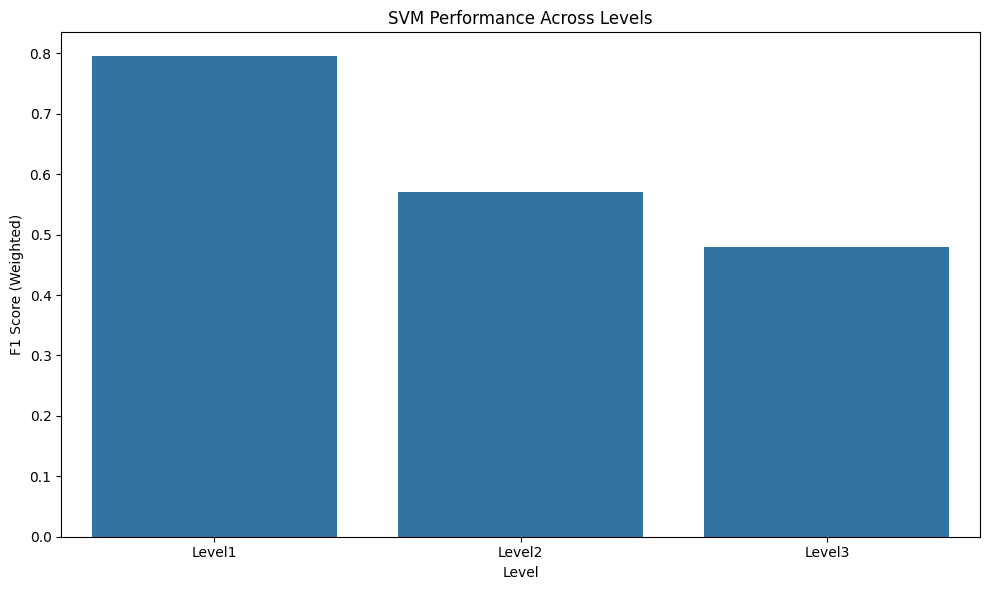

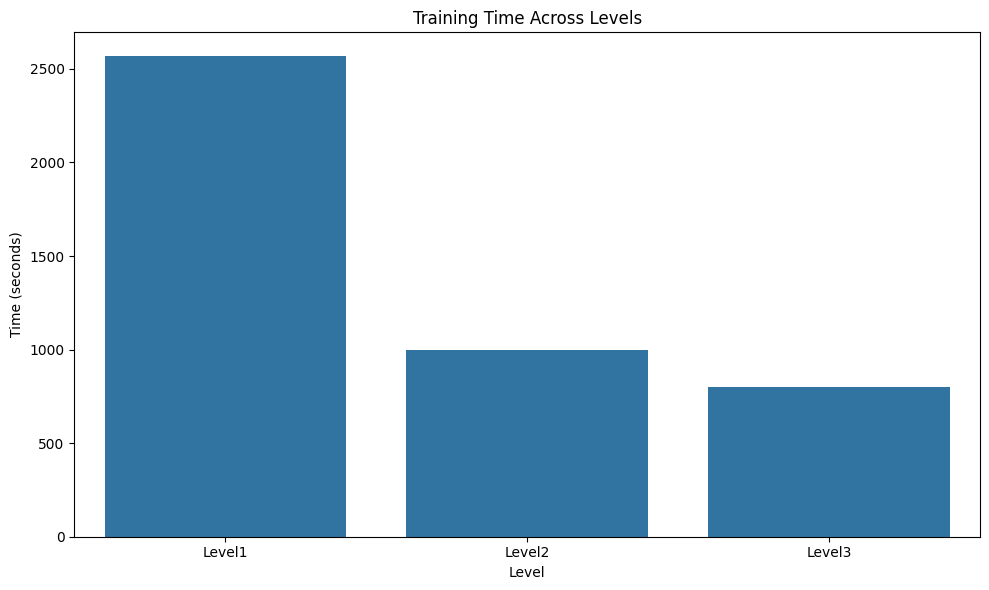


Saving results...
Results saved to 'svm_results.pkl'


In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

def preprocess_text(df):
    """Preprocess text data by handling NaN values and cleaning text"""
    # Fill NaN values
    df['Text'] = df['Text'].fillna('')
    df['Title'] = df['Title'].fillna('')
    
    # Basic text cleaning
    df['Text'] = df['Text'].astype(str).str.lower().str.strip()
    df['Title'] = df['Title'].astype(str).str.lower().str.strip()
    
    # Combine text and title
    df['combined_text'] = df['Text'] + ' ' + df['Title']
    
    return df

class SVMTuner:
    def __init__(self):
        self.best_params = {}
        self.best_models = {}
        self.results = {}
        self.scaler = StandardScaler()
        
    def tune_svm(self, X_train, X_test, y_train, y_test, category_level):
        """Tune SVM hyperparameters for each category level"""
        print(f"\nTuning SVM for {category_level}")
        
        try:
            # Scale the features
            X_train_scaled = self.scaler.fit_transform(X_train.toarray())
            X_test_scaled = self.scaler.transform(X_test.toarray())
            
            # Define parameter grid
            param_grid = {
                'C': [0.1, 1, 10],
                'kernel': ['linear', 'rbf'],
                'gamma': ['scale', 'auto'],
                'class_weight': ['balanced']
            }
            
            # Initialize SVM
            svm = SVC(random_state=42, probability=True)
            
            # Perform grid search
            print("Starting Grid Search...")
            grid_search = GridSearchCV(
                svm,
                param_grid,
                cv=3,
                n_jobs=-1,
                verbose=2,
                scoring='f1_weighted'
            )
            
            # Time the training
            start_time = time()
            grid_search.fit(X_train_scaled, y_train)
            training_time = time() - start_time
            
            # Store results
            self.best_params[category_level] = grid_search.best_params_
            self.best_models[category_level] = grid_search.best_estimator_
            
            # Make predictions
            y_pred = grid_search.predict(X_test_scaled)
            
            # Store results
            self.results[category_level] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'training_time': training_time,
                'test_predictions': y_pred,
                'classification_report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }
            
            # Print results
            print(f"\nBest parameters for {category_level}:")
            print(grid_search.best_params_)
            print(f"\nBest cross-validation score: {grid_search.best_score_:.3f}")
            print(f"\nTraining time: {training_time:.2f} seconds")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            
            return self.results[category_level]
            
        except Exception as e:
            print(f"Error in tune_svm for {category_level}: {str(e)}")
            return None

def main():
    # Load your data
    print("Loading data...")
    df = pd.read_csv('transformed_dataset.csv')
    
    # Preprocess text
    print("Preprocessing text...")
    df = preprocess_text(df)
    
    # Prepare features
    print("Preparing features...")
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    # Configure vectorizer
    vectorizer = TfidfVectorizer(
        max_features=1000,
        ngram_range=(1, 2),
        stop_words='english',
        strip_accents='unicode',
        min_df=2
    )
    
    # Fit and transform the text
    print("Vectorizing text...")
    X = vectorizer.fit_transform(df['combined_text'])
    
    # Get targets
    print("Preparing targets...")
    y1 = df['Cat1']
    y2 = df['Cat2']
    y3 = df['Cat3']
    
    # Print some basic statistics
    print("\nDataset Statistics:")
    print(f"Total samples: {len(df)}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of unique categories:")
    print(f"Level 1: {len(y1.unique())}")
    print(f"Level 2: {len(y2.unique())}")
    print(f"Level 3: {len(y3.unique())}")
    
    # Split data
    print("\nSplitting data...")
    X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(
        X, y1, y2, y3, test_size=0.2, random_state=42
    )
    
    # Initialize tuner
    svm_tuner = SVMTuner()
    
    # Tune and evaluate for each level
    results = {}
    for level, (y_train, y_test) in enumerate([
        (y1_train, y1_test),
        (y2_train, y2_test),
        (y3_train, y3_test)
    ], 1):
        print(f"\nProcessing Level {level}")
        result = svm_tuner.tune_svm(
            X_train, X_test, y_train, y_test, f'Level{level}'
        )
        if result is not None:
            results[f'Level{level}'] = result
    
    return svm_tuner, results

def analyze_results(results):
    """Analyze results across all levels"""
    if not results:
        print("No results to analyze!")
        return
    
    summary = []
    
    for level, result in results.items():
        if result is not None:
            summary.append({
                'Level': level,
                'Best Score': result['best_score'],
                'Training Time': result['training_time'],
                'Best Parameters': result['best_params']
            })
    
    if summary:
        summary_df = pd.DataFrame(summary)
        
        print("\nSummary of Results:")
        print(summary_df.to_string())
        
        # Plot performance comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(data=summary_df, x='Level', y='Best Score')
        plt.title('SVM Performance Across Levels')
        plt.ylabel('F1 Score (Weighted)')
        plt.tight_layout()
        plt.show()
        
        # Plot training time comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(data=summary_df, x='Level', y='Training Time')
        plt.title('Training Time Across Levels')
        plt.ylabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    try:
        # Run main analysis
        print("Starting analysis...")
        svm_tuner, results = main()
        
        # Analyze results
        print("\nAnalyzing results...")
        analyze_results(results)
        
        # Save results
        print("\nSaving results...")
        import pickle
        with open('svm_results.pkl', 'wb') as f:
            pickle.dump({
                'tuner': svm_tuner,
                'results': results
            }, f)
        print("Results saved to 'svm_results.pkl'")
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
